# Exploração dos dados de e-commerce da Olist

O objetivo desse projeto é analisar o conjunto de dados de e-commerce da Olist Store durante o período de 2016 a 2018. Tratam-se de dados reais de empresas que utilizam o serviço da Olist de ecommerce. Para garantia da privacidade, todos os textos identificados lojas e parceiros nominalmente foram substituídos por nomes de casas de Game of Thrones. 

Com o objetivo de praticar o request de dados em formato de bancos de dados relacionais, como numa situação de negócios reais, o requerimento e manipulação dos dados foi realizado em linguagem sqlite sempre que possível.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [3]:
fnames = os.listdir('csv')
print(fnames)

# dicionário com os dataframes
frames = {}
for file in fnames:
    chave = file.replace('.csv','').replace('_dataset','')
    arquivo = os.path.join('csv', file)
    frames[chave] = pd.read_csv(arquivo)

['olist_customers_dataset.csv', 'olist_geolocation_dataset.csv', 'olist_orders_dataset.csv', 'olist_order_items_dataset.csv', 'olist_order_payments_dataset.csv', 'olist_order_reviews_dataset.csv', 'olist_products_dataset.csv', 'olist_sellers_dataset.csv', 'product_category_name_translation.csv']


In [4]:
# Criando banco de dados em memória
from sqlalchemy import create_engine
# cria uma conexão com um banco de dados SQLite em memória
# sqlalchemy cria o banco em memória
engine = create_engine('sqlite://', echo=False)

for chave, df in frames.items():
    df.to_sql(chave, con=engine)

In [5]:
# checando tabelas criadas
query = """
SELECT name FROM sqlite_master WHERE type='table';
"""

df_query = pd.read_sql_query(query, con=engine)
df_query

,name
0,olist_customers
1,olist_geolocation
2,olist_orders
3,olist_order_items
4,olist_order_payments
5,olist_order_reviews
6,olist_products
7,olist_sellers
8,product_category_name_translation


In [6]:
# testando uma query simples
query = '''
Select * from olist_customers
limit 10
'''

df_query = pd.read_sql_query(query, con=engine)
df_query

,index,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP
5,5,879864dab9bc3047522c92c82e1212b8,4c93744516667ad3b8f1fb645a3116a4,89254,jaragua do sul,SC
6,6,fd826e7cf63160e536e0908c76c3f441,addec96d2e059c80c30fe6871d30d177,4534,sao paulo,SP
7,7,5e274e7a0c3809e14aba7ad5aae0d407,57b2a98a409812fe9618067b6b8ebe4f,35182,timoteo,MG
8,8,5adf08e34b2e993982a47070956c5c65,1175e95fb47ddff9de6b2b06188f7e0d,81560,curitiba,PR
9,9,4b7139f34592b3a31687243a302fa75b,9afe194fb833f79e300e37e580171f22,30575,belo horizonte,MG


In [7]:
# função wrapper de read_sql_query
def rq(q):
    return pd.read_sql_query(q, con=engine)

In [8]:
# 3 primeiras linhas de cada tabela para referência

nomes_tabelas = rq(
    """SELECT name FROM sqlite_master WHERE type='table';"""
)

for name in nomes_tabelas.values:
    print(name, '\n', rq(f"PRAGMA table_info({name[0]})"))
    print(rq(f"SELECT * FROM {name[0]} LIMIT 3"))

['olist_customers'] 
    cid                      name    type  notnull dflt_value  pk
0    0                     index  BIGINT        0       None   0
1    1               customer_id    TEXT        0       None   0
2    2        customer_unique_id    TEXT        0       None   0
3    3  customer_zip_code_prefix  BIGINT        0       None   0
4    4             customer_city    TEXT        0       None   0
5    5            customer_state    TEXT        0       None   0
   index                       customer_id                customer_unique_id  \
0      0  06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1      1  18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac935b93aa66c333dc3   
2      2  4e7b3e00288586ebd08712fdd0374a03  060e732b5b29e8181a18229c7b0b2b5e   

   customer_zip_code_prefix          customer_city customer_state  
0                     14409                 franca             SP  
1                      9790  sao bernardo do campo             SP 

### Visão geral dos clientes  e lojas

- Estados com maior número de consumidores e maior número de lojas

In [9]:
# Número de consumidores por estados
sql = '''
SELECT customer_state, COUNT(1) AS n_consumers
FROM
(
    SELECT DISTINCT customer_unique_id, customer_state
    FROM olist_customers
)
GROUP BY customer_state
ORDER BY n_consumers DESC
LIMIT 10
'''

df1 = rq(sql)

In [10]:
# Número de lojas por estados
sql = '''
SELECT seller_state as states, COUNT(1) AS n_sellers
FROM olist_sellers
GROUP BY seller_state
ORDER BY n_sellers DESC
LIMIT 10
'''
df2 = rq(sql)

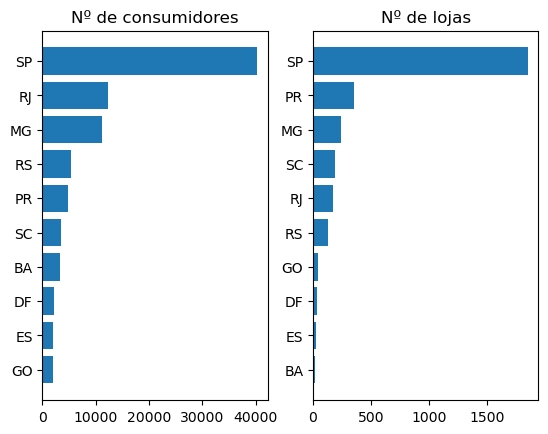

In [11]:
fig, ax = plt.subplots(1, 2)

ax[0].barh(df1.index, df1['n_consumers'])
ax[0].set_yticks(df1.index, labels=df1['customer_state'])
ax[0].set_title('Nº de consumidores')
ax[0].invert_yaxis()

ax[1].barh(df2.index, df2['n_sellers'])
ax[1].set_yticks(df2.index, labels=df2['states'])
ax[1].set_title('Nº de lojas')
ax[1].invert_yaxis()


De forma geral as lojas e consumidores consumidores estão concentrados no eixo sudeste e sul, em especial no estado de São Paulo. Comparativamente o Rio de Janeiro consome bastante mas possui poucas lojas, enquanto o Paraná possui muitas lojas e comparativamente menos consumidores

- Em quais dias da semana são realizadas mais compras?

([<matplotlib.axis.XTick at 0x240810bdb40>,
 [Text(0, 0, 'D'),
  Text(1, 0, 'S'),
  Text(2, 0, 'T'),
  Text(3, 0, 'Q'),
  Text(4, 0, 'Q'),
  Text(5, 0, 'S'),
  Text(6, 0, 'S')])

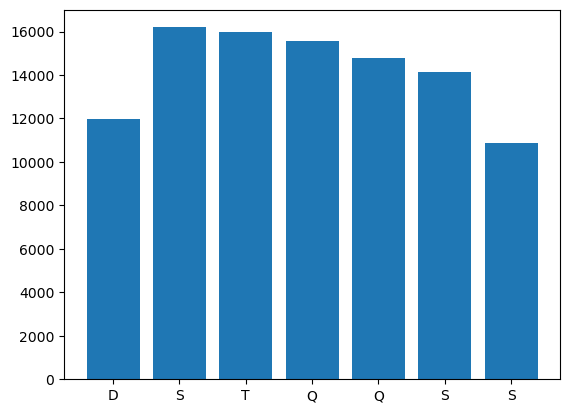

In [12]:
# extract não está disponível no sqlite3
df = rq(
    """SELECT COUNT(order_id) AS qt_orders,
    strftime('%w', order_purchase_timestamp) AS week_day
    FROM olist_orders
    GROUP BY week_day"""
)

iniciais = list('DSTQQSS')
plt.bar(df.index, df['qt_orders'])
plt.xticks(range(7), iniciais)


O maior número de vendas ocorre nas segundas e decai ao longo da semana. No final de semana, a quantidade de vendas diminui

- Quais as categorias mais vendidas?

Text(0.5, 1.0, 'Número de produtos vendidos por categoria')

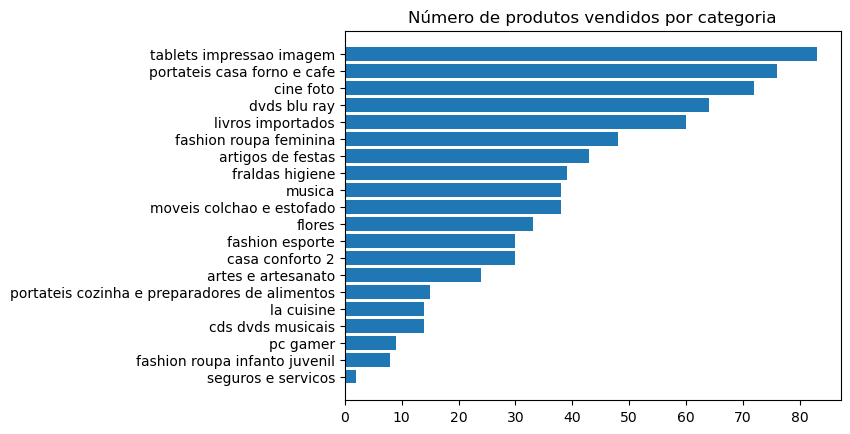

In [13]:
sql = '''
select count(1) as n_sells, p.product_category_name as category
from olist_order_items i
inner join olist_products p
ON i.product_id=p.product_id
group by p.product_category_name
order by n_sells
limit 20
'''

df = rq(sql)

plt.barh(df.index, df['n_sells'])
ax = plt.gca()
ax.set_yticks(df.index, labels=df['category'].str.replace('_',' '))
ax.set_title('Número de produtos vendidos por categoria')

# algumas dessas categorias podem ser agrupadas

- Quais são as lojas mais frequentemente avaliadas com 5 estrelas?

Text(0.5, 1.0, 'Lojas mais frequentemente avaliadas com 5 estrelas')

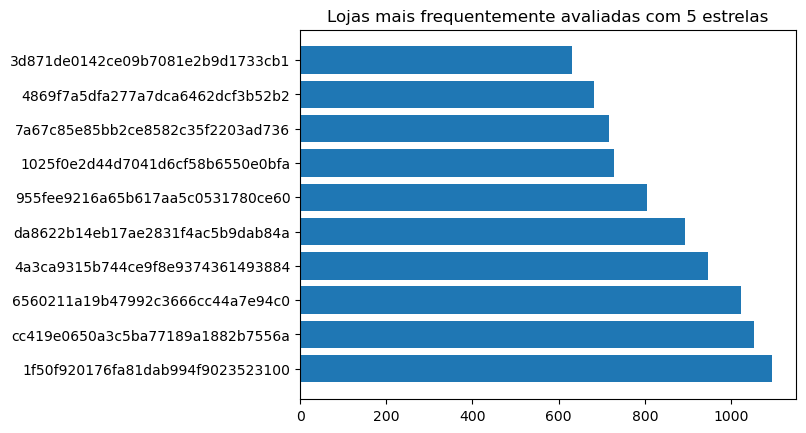

In [14]:
sql = '''
SELECT s.seller_id, COUNT(*) AS num_reviews
FROM olist_sellers s
INNER JOIN olist_order_items oi ON s.seller_id = oi.seller_id
INNER JOIN olist_orders o ON oi.order_id = o.order_id
INNER JOIN olist_order_reviews r ON o.order_id = r.order_id
WHERE r.review_score = 5
GROUP BY s.seller_id
ORDER BY num_reviews DESC
LIMIT 10
'''

df = rq(sql)

plt.barh(df.index, df['num_reviews'])
ax = plt.gca()
ax.set_yticks(df.index, labels=df['seller_id'])
ax.set_title('Lojas mais frequentemente avaliadas com 5 estrelas')


Como os nomes das lojas foram omitidos, não tem como saber a que ids se referem as lojas

- Número de pedidos por consumidor

In [15]:
df = rq(
    """
    SELECT c.customer_unique_id, COUNT(1) as n_orders
    FROM 'olist_orders' o
    INNER JOIN 'olist_customers' c  
    ON o.customer_id=c.customer_id
    GROUP BY c.customer_unique_id
    ORDER BY n_orders
    """
)

df['n_orders'].value_counts()

1     93099
2      2745
3       203
4        30
5         8
6         6
7         3
9         1
17        1
Name: n_orders, dtype: int64

A grande maioria dos clientes fez apensa 1 pedido.  Muito raro um cliente fazer mais de 3 pedidos.
Dados indicam que pode ser importante investir em campanhas para fidelizar os clientes.

### Satisfação dos clientes e comentários

- Distribuição de avaliações dos clientes que escreveram comentários

In [16]:
df = rq(
    """SELECT review_score FROM olist_order_reviews
    WHERE review_comment_title IS NOT NULL 
    OR review_comment_message IS NOT NULL"""
)
df.value_counts()


review_score
5               21790
1                8829
4                6278
3                3644
2                2165
dtype: int64

<BarContainer object of 5 artists>

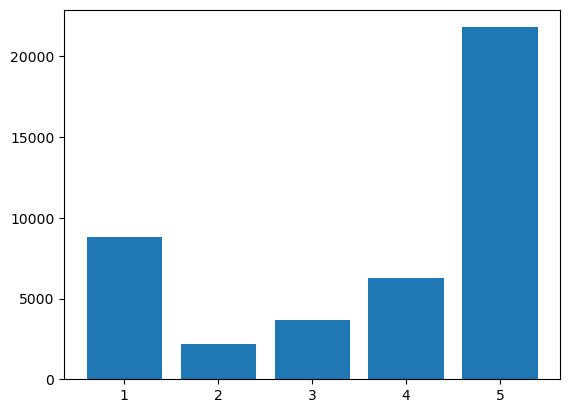

In [17]:
hst = df.value_counts()
ratings = [n[0] for n in hst.index] # desempacotando tuplas
plt.bar(ratings, hst.values )

Clientes muito satisfeitos (5 stars) usualmente deixam mais comentários, seguido de clientes muito insatisfeitos (1 star)

- Existe relação entre as avaliações e o tamanho dos comentários?

In [18]:
df = rq(
    """SELECT review_score,
    LENGTH(review_comment_message) AS length
    FROM olist_order_reviews
    WHERE review_comment_message IS NOT NULL
    ORDER BY review_score, length"""
)

df

,review_score,length
0,1,1
1,1,1
2,1,1
3,1,1
4,1,1
...,...,...
40972,5,202
40973,5,203
40974,5,203
40975,5,204


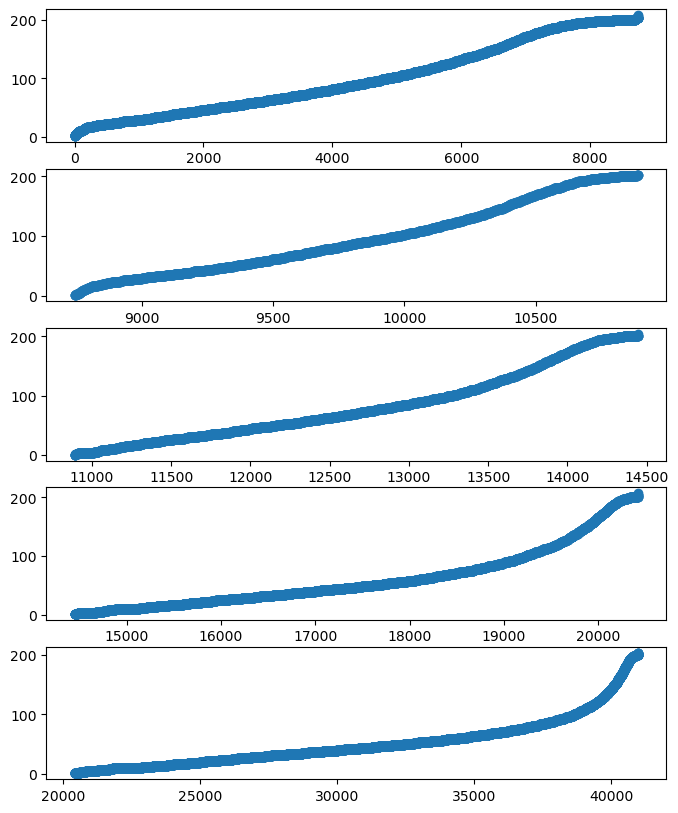

In [19]:
fig, ax = plt.subplots(5, 1, figsize=(8,10))

for n in range(5):
    dfn = df[df['review_score'] == n+1]
    ax[n].scatter(dfn.index, dfn['length'])

# parece existir um limite de 200 caracteres. A curva parece indicar 
# menores comentários em avaliações positivas

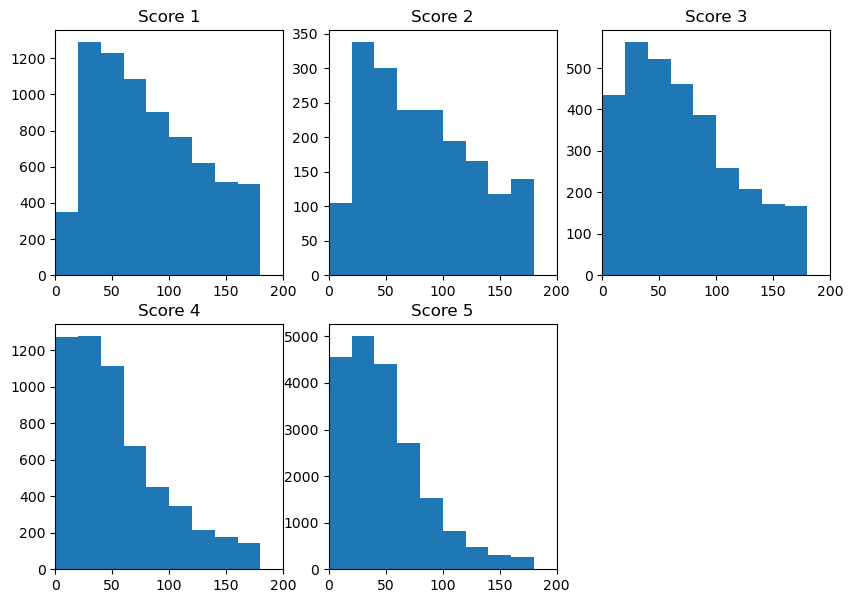

In [20]:
fig, ax = plt.subplots(2, 3, figsize=(10,7))
ax = ax.flatten()
fig.delaxes(ax[-1])

for n in range(5):
    dfn = df[df['review_score'] == n+1]
    ax[n].set_title(f"Score {n+1}")
    ax[n].hist(dfn['length'], bins=np.arange(0, 200, 20))
    ax[n].set_xlim([0, 200])

### Crescimento dos negócios ao longo do tempo

- Número de pedidos e receita ao longo do tempo

In [21]:
df = rq(
    """WITH time AS
    (
        SELECT DATE(order_purchase_timestamp) AS purchase_date
        FROM `olist_orders`
    )
    SELECT COUNT(1) AS num_orders, purchase_date
    FROM time
    GROUP BY purchase_date
    ORDER BY purchase_date 
    """
)
df

,num_orders,purchase_date
0,1,2016-09-04
1,1,2016-09-05
2,1,2016-09-13
3,1,2016-09-15
4,1,2016-10-02
...,...,...
629,1,2018-09-29
630,1,2018-10-01
631,1,2018-10-03
632,1,2018-10-16


In [22]:
all(df['num_orders'] == 1) # testando se tem variações nos dados

False

Text(0, 0.5, 'Número de pedidos')

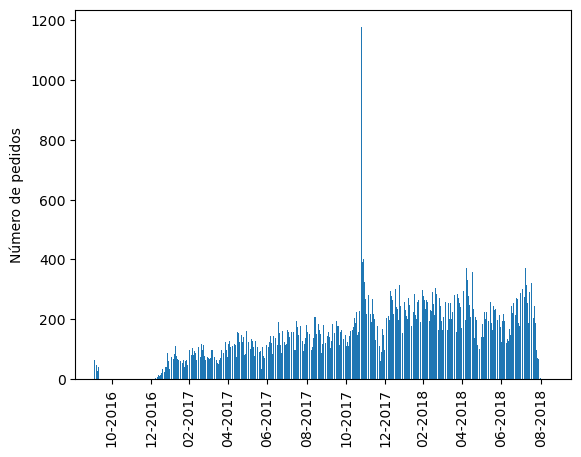

In [23]:
df['dt'] = pd.to_datetime(df['purchase_date'])
df = df.set_index('dt')

plt.bar(df.index, df['num_orders'])
plt.xlim(min(df.index), max(df.index))

tticks = pd.date_range('2016-10-1', '2018-10-1', freq='2M')
plt.xticks(tticks, labels=tticks.strftime('%m-%Y'), rotation=90)
plt.ylabel('Número de pedidos')


Text(0, 0.5, 'Receita ao longo do tempo (Reais)')

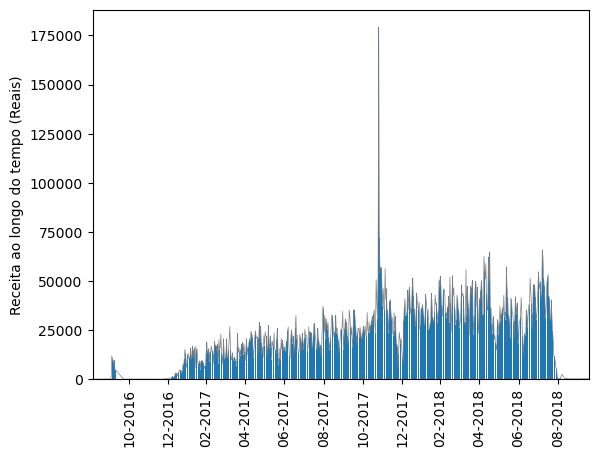

In [24]:
df = rq(
    """
    WITH faturamento AS
    (
        SELECT DATE(o.order_purchase_timestamp) as days,
        p.payment_value AS payments
        FROM 'olist_order_payments' p
        INNER JOIN 'olist_orders' o ON o.order_id=p.order_id
    )
    SELECT days, sum(payments) AS payments
    FROM faturamento
    GROUP BY days
    ORDER BY days
    """
)

df['dt'] = pd.to_datetime(df['days'])
df = df.set_index('dt')

plt.bar(df.index, df['payments'])
# adicionada linha para mostrar o outlier em 11-2017
plt.plot(df.index, df['payments'], color='gray', linewidth=0.5)
plt.xlim(min(df.index), max(df.index))

tticks = pd.date_range('2016-10-1', '2018-10-1', freq='2M')
plt.xticks(tticks, labels=tticks.strftime('%m-%Y'), rotation=90)
plt.ylabel('Receita ao longo do tempo (Reais)')

# a receita foi condizente com o número de pedidos de forma geral

As séries indicam um tendência de crescimento ao longo do tempo e um aparente ciclo semanal. 
Também é notável no gráfico um pico em 11-2017, provavelmente em decorrência de uma promoção pontual